<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

# Ames, Iowa:
- Pop: ~60k
- Its a Collegetown: ISU
- Size: ~25sqmiles

# Ideas:
- Open concept = 1st floor sqft / first floor # rooms
- School district per neighborhood
- Ratio of Bedrooms to bathrooms
- Yard size
- Amount of rooms * Quality

<img src='http://cdn.ames.k12.ia.us/wp-content/uploads/2015/02/boundary20142-gray.jpg' style='width:300px'>


In [429]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [975]:
# Load the data
h = pd.read_csv('./housing.csv')

In [431]:
orig = pd.read_csv('./housing.csv')

In [976]:
h.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


# Quick exploration of the data

# Neighborhood: Physical locations within Ames city limits

       Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       IDOTRR	Iowa DOT and Rail Road
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker

# Since real estate is usually all about location, I bet the prices of the neighborhoods will differ.
Very interesting to see the top three neighborhoods have average salep rices ~120k above the Ames average sale price. I bet some of these will be very good predictors.

In [432]:
(h.groupby('Neighborhood')['SalePrice'].mean() / h.groupby('Neighborhood')['GrLivArea'].mean()).sort_values(ascending=False)


Neighborhood
StoneBr   165.239905
NridgHt   165.072325
Veenker   155.083373
Somerst   141.157321
Timber    138.476834
Blmngtn   136.469207
CollgCr   133.714961
NoRidge   133.644702
Mitchel   120.746026
ClearCr   118.877105
Crawfor   117.561441
Gilbert   117.499584
SawyerW   116.961140
NPkVill   113.881883
Sawyer    112.574310
NAmes     111.307154
NWAmes    109.417814
BrkSide   103.762963
Blueste    98.743268
Edwards    95.682965
MeadowV    93.089212
BrDale     91.404953
IDOTRR     87.650562
OldTown    86.654576
SWISU      79.162688
dtype: float64

In [434]:
#h.groupby('Neighborhood').size().sort_values(ascending=False)
#pd.options.display.float_format = '{:,.2f}'.format
print(str('Mean saleprice for Ames dataset: ' + str(h['SalePrice'].mean())))
h.groupby('Neighborhood')['SalePrice'].describe().unstack().sort_values(by='mean',ascending=False)['mean']

Mean saleprice for Ames dataset: 180921.19589


Neighborhood
NoRidge   335,295.317073
NridgHt   316,270.623377
StoneBr   310,499.000000
Timber    242,247.447368
Veenker   238,772.727273
Somerst   225,379.837209
ClearCr   212,565.428571
Crawfor   210,624.725490
CollgCr   197,965.773333
Blmngtn   194,870.882353
Gilbert   192,854.506329
NWAmes    189,050.068493
SawyerW   186,555.796610
Mitchel   156,270.122449
NAmes     145,847.080000
NPkVill   142,694.444444
SWISU     142,591.360000
Blueste   137,500.000000
Sawyer    136,793.135135
OldTown   128,225.300885
Edwards   128,219.700000
BrkSide   124,834.051724
BrDale    104,493.750000
IDOTRR    100,123.783784
MeadowV    98,576.470588
Name: mean, dtype: float64

# Condition1: Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

# The condition feature is also an interesting one, PosA and PosN we expect will have a positive impact on price. Wouldn't expect to see RRNe to be positive
Taking a closer look it turns out being closer to the East-West railroad also benefits the price! Turns out you can get to chicago in ~4.5hrs via amtrak.

In [269]:
h.groupby('Condition1')[['SalePrice']].mean()
#h.groupby('Condition1')['SalePrice'].size()

,SalePrice
Condition1,
Artery,135091
Feedr,142475
Norm,184495
PosA,225875
PosN,215184
RRAe,138400
RRAn,184396
RRNe,190750
RRNn,212400


In [435]:
#Setup an odered list of neighborhoods
Ordered_Nbs = list(h.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending=False).index)

In [442]:
print('mean price for 5 best neighborhoods: ' + str(h[h['Neighborhood'].isin(Ordered_Nbs[:5])]['SalePrice'].mean()))
print('mean lotarea for 5 best neighborhoods: ' + str(h[h['Neighborhood'].isin(Ordered_Nbs[:5])]['LotArea'].mean()))
print('\n')
print('mean price for 5 worst neighborhoods: ' + str(h[h['Neighborhood'].isin(Ordered_Nbs[-5:])]['SalePrice'].mean()))
print('mean lotarea for 5 worst neighborhoods: ' + str(h[h['Neighborhood'].isin(Ordered_Nbs[-5:])]['LotArea'].mean()))

mean price for 5 best neighborhoods: 300491.270833
mean lotarea for 5 best neighborhoods: 14370.0625


mean price for 5 worst neighborhoods: 118923.79386
mean lotarea for 5 worst neighborhoods: 7969.87719298


# BldgType: Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit

# Some types of houses are more desireable than others as well. Detached single familys and the townhouses on the end of the block have the highest mean price

In [283]:
h.groupby('BldgType')['SalePrice'].mean()

BldgType
1Fam      185763
2fmCon    128432
Duplex    133541
Twnhs     135911
TwnhsE    181959
Name: SalePrice, dtype: int64

# To get a feel for what type of houses are in ames I did a quick gmaps streetview look around. 

# There are nice victorians and alot of ranches
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Carey_house_denison_iowa.jpg/800px-Carey_house_denison_iowa.jpg',style='width:300px'><img src='http://images.housesforsalelists.com/Images/Houses/ia/ames/3318-southdale-dr-ames-iowa-50010.jpg',style='width:300px'>
# And there are some very nice townhouses
<img src='https://thumbs.frmonline.com/imgs/fr/propertyFiles/865/591/1000/resized/08_139698905401514141024076890008020.jpg',style='width:300px'>

# Take a look at the mean price by type and neighborhood! 
- Interesting to see in the nicest neighborhoods single familys are most valueable, while the townhouses trend better in average neighborhoods especially crawford and bloomington.
- In long term realestate plays, it might be a good idea to pick up the single family houses in a neighborhood on the cusp of becoming a 'nice' neighborhood because they have a higher topout.

In [456]:
h.groupby(['Neighborhood','BldgType'])['SalePrice'].mean().unstack().sort_values(by='1Fam',ascending=False)

BldgType,1Fam,2fmCon,Duplex,Twnhs,TwnhsE
Neighborhood,,,,,
StoneBr,"393,267.000000",nan,nan,nan,"220,833.000000"
NridgHt,"351,629.000000",nan,nan,"192,214.000000","244,514.000000"
NoRidge,"335,295.000000",nan,nan,nan,nan
Somerst,"247,923.000000",nan,nan,"167,533.000000","180,410.000000"
Timber,"242,606.000000","228,950.000000",nan,nan,nan
Veenker,"223,375.000000",nan,nan,nan,"279,833.000000"
ClearCr,"212,565.000000",nan,nan,nan,nan
Crawfor,"208,719.000000","157,000.000000","145,000.000000",nan,"300,833.000000"
CollgCr,"201,858.000000",nan,nan,nan,"143,470.000000"


# Condition2: Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

# Define fixed/non-fixed features

### 'Fixed': 
'MSSubClassCat'
,'MSZoning'
,'LotFrontage'
,'LotArea'
,'Street'
,'Alley'
,'LotShape'
,'LandContour'
,'Utilities'
,'LotConfig'
,'LandSlope'
,'Neighborhood'
,'Condition1'
,'Condition2'
,'BldgType'
,'YearBuilt'
,'YearRemodAdd'
,'RoofStyle'
,'Foundation'
,'BsmtQual'
,'BsmtExposure'
,'GarageYrBlt'
,'MoSold'
,'YrSold'
,'SaleType'
,'SaleCondition'
,'SalePrice'

### 'Non-Fixed': 
'HouseStyle'
,'OverallQual'
,'OverallCond'
,'RoofMatl'
,'Exterior1st'
,'Exterior2nd'
,'MasVnrType'
,'MasVnrArea'
,'ExterQual'
,'ExterCond'
,'BsmtCond'
,'BsmtFinType1'
,'BsmtFinSF1'
,'BsmtFinType2'
,'BsmtFinSF2'
,'BsmtUnfSF'
,'TotalBsmtSF'
,'Heating'
,'HeatingQC'
,'CentralAir'
,'Electrical'
,'1stFlrSF'
,'2ndFlrSF'
,'LowQualFinSF'
,'GrLivArea'
,'BsmtFullBath'
,'BsmtHalfBath'
,'FullBath'
,'HalfBath'
,'BedroomAbvGr'
,'KitchenAbvGr'
,'KitchenQual'
,'TotRmsAbvGrd'
,'Functional'
,'Fireplaces'
,'FireplaceQu'
,'GarageType'
,'GarageFinish'
,'GarageCars'
,'GarageArea'
,'GarageQual'
,'GarageCond'
,'PavedDrive'
,'WoodDeckSF'
,'OpenPorchSF'
,'EnclosedPorch'
,'3SsnPorch'
,'ScreenPorch'
,'PoolArea'
,'PoolQC'
,'Fence'
,'MiscFeature'
,'MiscVal'

In [611]:
#create dict from string above, manually selected
feature_dict = {
    'fixed': ['MSSubClassCat'
,'MSZoning'
,'LotFrontage'
,'LotArea'
,'Street'
,'Alley'
,'LotShape'
,'LandContour'
,'Utilities'
,'LotConfig'
,'LandSlope'
,'Neighborhood'
,'Condition1'
,'Condition2'
,'BldgType'
,'YearBuilt'
,'YearRemodAdd'
,'RoofStyle'
,'Foundation'
,'BsmtQual'
,'BsmtExposure'
,'GarageYrBlt'
,'MoSold'
,'YrSold'
,'SaleType'
,'SaleCondition'
,'SalePrice'],
    'non-fixed': ['HouseStyle'
,'OverallQual'
,'OverallCond'
,'RoofMatl'
,'Exterior1st'
,'Exterior2nd'
,'MasVnrType'
,'MasVnrArea'
,'ExterQual'
,'ExterCond'
,'BsmtCond'
,'BsmtFinType1'
,'BsmtFinSF1'
,'BsmtFinType2'
,'BsmtFinSF2'
,'BsmtUnfSF'
,'TotalBsmtSF'
,'Heating'
,'HeatingQC'
,'CentralAir'
,'Electrical'
,'1stFlrSF'
,'2ndFlrSF'
,'LowQualFinSF'
,'GrLivArea'
,'BsmtFullBath'
,'BsmtHalfBath'
,'FullBath'
,'HalfBath'
,'BedroomAbvGr'
,'KitchenAbvGr'
,'KitchenQual'
,'TotRmsAbvGrd'
,'Functional'
,'Fireplaces'
,'FireplaceQu'
,'GarageType'
,'GarageFinish'
,'GarageCars'
,'GarageArea'
,'GarageQual'
,'GarageCond'
,'PavedDrive'
,'WoodDeckSF'
,'OpenPorchSF'
,'EnclosedPorch'
,'3SsnPorch'
,'ScreenPorch'
,'PoolArea'
,'PoolQC'
,'Fence'
,'MiscFeature'
,'MiscVal'
,'SalePrice']
}

#pprint(feature_dict)

In [22]:
#confirm all features are in dict
j = 0
for i, feature in enumerate(feature_dict.keys()):
    #pprint(feature_dict[feature])
    j += len(feature_dict[feature])
#print(j)

# Elementary Schools and ratings:
- Expect the northwest part of town to be the highest priced based on scool districts


http://www.greatschools.org/iowa/ames/schools/
http://www.ames.k12.ia.us/boundaries/

In [61]:
elem_rating = {
    'Edwards': 8,
    'Sawyer': 9,
    'Fellows': 9,
    'Meeker': 7,
    'Mitchell': 7
}

# Remove commercial properties from the dataset

In [457]:
h.groupby(['MSZoning']).size()

MSZoning
C (all)      10
FV           65
RH           16
RL         1151
RM          218
dtype: int64

In [458]:
h = h[h['MSZoning'] != 'C (all)']

In [459]:
h.groupby(['MSZoning']).size()

MSZoning
FV      65
RH      16
RL    1151
RM     218
dtype: int64

# Set Id as index

In [460]:
h.set_index('Id',inplace=True)

# Take a look at hist and top pair plots

In [290]:
#h.hist(bins=50,figsize=(20,20))

# Remove cols with less than 90% data in cols

In [461]:
#keep all columns that have more than 10% null values
print((1 - (h.isnull().sum().sort_values(ascending=False) / len(h)) < .9).head(10))
h.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','LotFrontage'],axis=1,inplace=True)

PoolQC           True
MiscFeature      True
Alley            True
Fence            True
FireplaceQu      True
LotFrontage      True
GarageType      False
GarageCond      False
GarageFinish    False
GarageQual      False
dtype: bool


# Convert MSSubClass to cat

In [462]:
def MSconvert(num):
    MS_dict = {
        20: '1STORY1946',
        30: '1STORY1945',
        40: '1STORYATTIC',
        45: '1.5STORYUNFIN',
        50: '1.5STORYFIN',
        60: '2STORY1946N',
        70: '2STORY1945O',
        75: '2.5STORY',
        80: 'SPLITLEVEL',
        85: 'SPLITFOYER',
        90: 'DUPLEX',
       120: '1STORYPUD',
       150: '1.5STORYPUD',
       160: '2STORYPUD',
       180: 'MULTILEVELPUD',
       190: '2FAMILY'}
    return MS_dict[num]

MSconvert(orig['MSSubClass'][0])

'2STORY1946N'

In [463]:
h['MSSubClassCat'] = h['MSSubClass'].apply(MSconvert)

In [464]:
h.drop('MSSubClass',axis=1,inplace=True)

# Take copy

In [465]:
hcopy = h.copy()

# Function to fillna with median (numerics only)

In [466]:
#np.median(h['GarageYrBlt'])
#h.info()

In [467]:
for col in h.columns:
    if h[col].dtype != 'object':
        h[col].fillna(value = h[col].median(), inplace=True)

In [468]:
for col in h.columns:
    if h[col].dtype == 'object':
        h[col].fillna(value = 'None', inplace=True)

# Take a look at NaNs

In [469]:
h.isnull().sum().sort_values(ascending=False).head()

MSSubClassCat    0
RoofMatl         0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
dtype: int64

# Correlation matrix

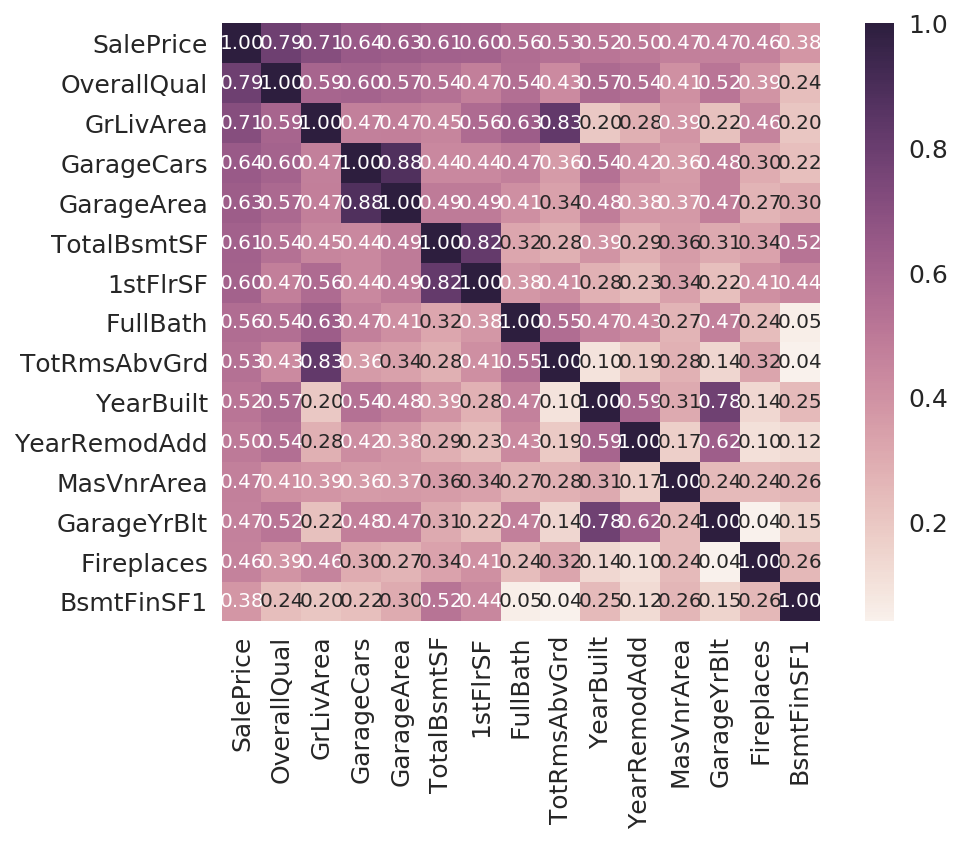

In [316]:
#saleprice correlation matrix
k = 15 #number of variables for heatmap
corr = h.corr()
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(h[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, 
                 fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Pairplot top corrs
- Overall Qual is the best indicator, interesting as this definately a Non-Fixed somewhat subjective valiable. It ties right into the obsession that realestate brokers have with 'staging' a house with higher quality art and such.
- GrLivArea makes sense as well, since we generally think of larger houses as higher price.
- I'm somewhat surprised with the next two garage variables, though garages are imortant in suburbia, I didn't expect them to play this large of a roll.

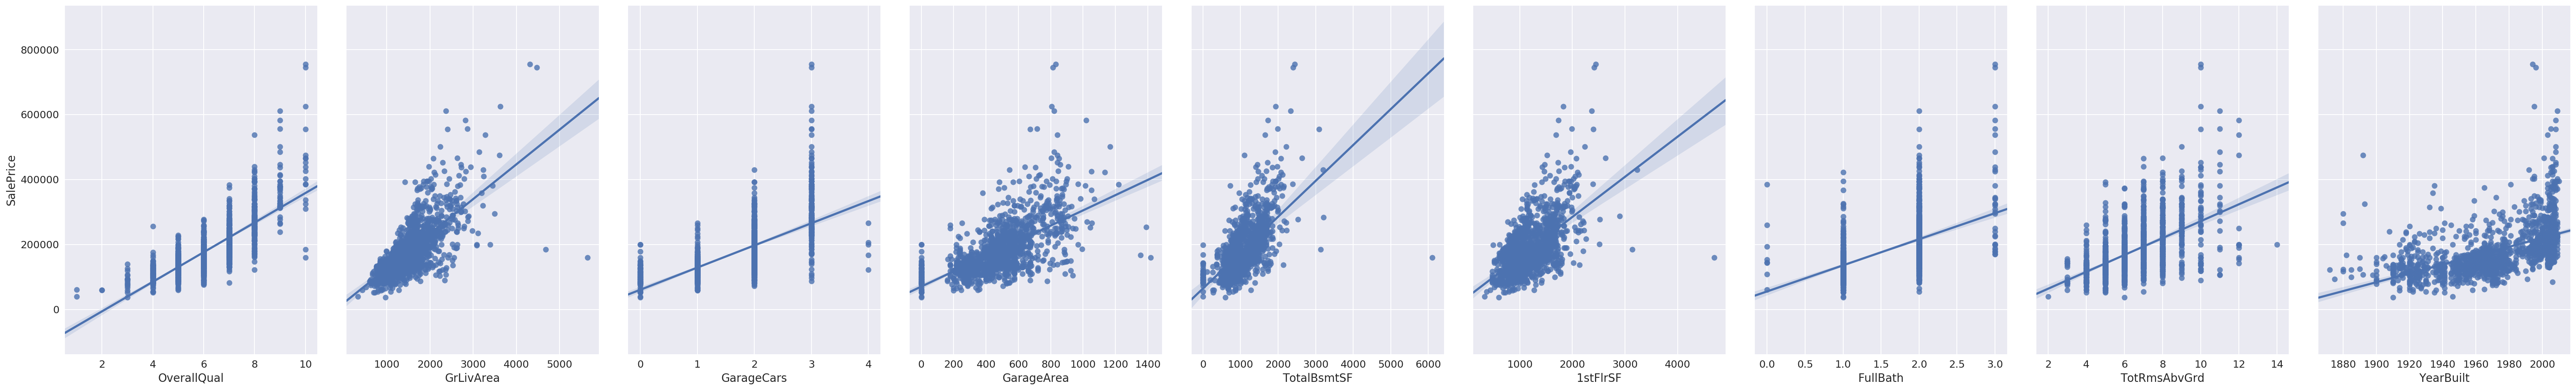

In [318]:
sns.pairplot(h, 
             x_vars=['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
             y_vars=['SalePrice'],size=7,aspect=.7,kind='reg')

# Take a look at distributions, looks like a few of the top candidates are not normally distributed

In [319]:
from scipy.stats import norm

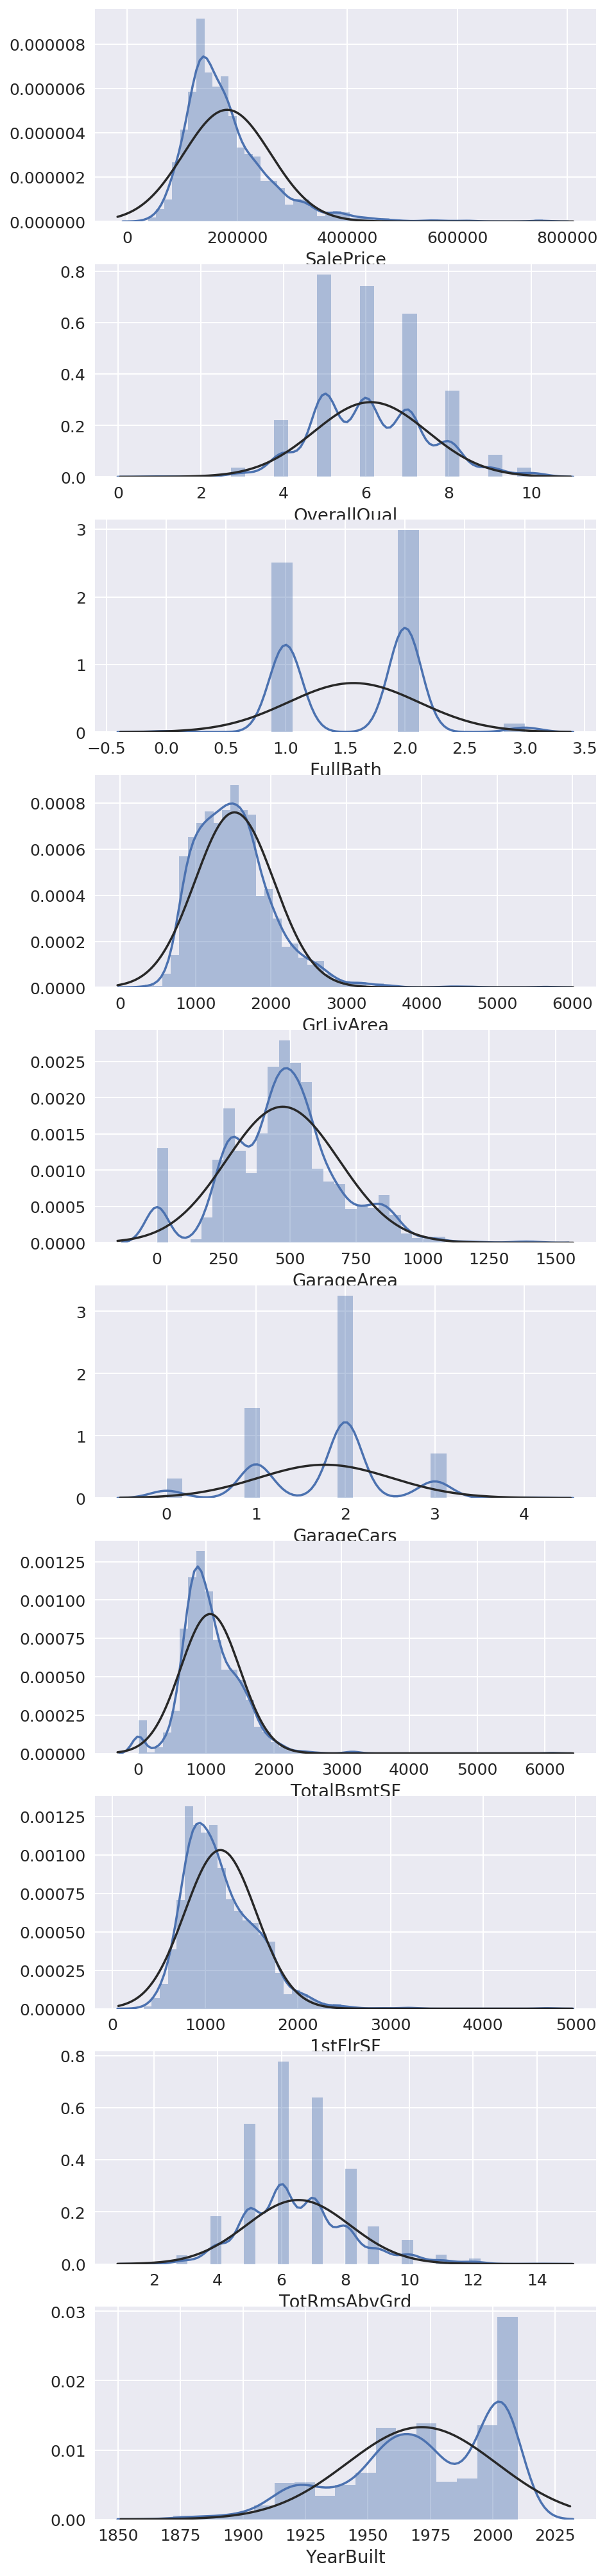

In [320]:
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10) = plt.subplots(10,figsize=(7,36))
sns.distplot(h['SalePrice'], fit=norm, ax=ax1)
sns.distplot(h['OverallQual'], fit=norm, ax=ax2)
sns.distplot(h['FullBath'], fit=norm, ax=ax3)
sns.distplot(h['GrLivArea'], fit=norm, ax=ax4)
sns.distplot(h['GarageArea'], fit=norm, ax=ax5)
sns.distplot(h['GarageCars'], fit=norm, ax=ax6)
sns.distplot(h['TotalBsmtSF'], fit=norm, ax=ax7)
sns.distplot(h['1stFlrSF'], fit=norm, ax=ax8)
sns.distplot(h['TotRmsAbvGrd'], fit=norm, ax=ax9)
sns.distplot(h['YearBuilt'], fit=norm, ax=ax10)

# Save cleaned no_transforms dataframe

In [479]:
h_no_transforms = h.copy()

In [519]:
#h_no_log = h_no_transforms.copy()

# Transform the variables that are not normally distributed - linear regression assumes values are normally distributed
- log transform salesprice, grlivarea, 1stflrsq, 
- do something about the 0's in garagearea, totalbsmtsf

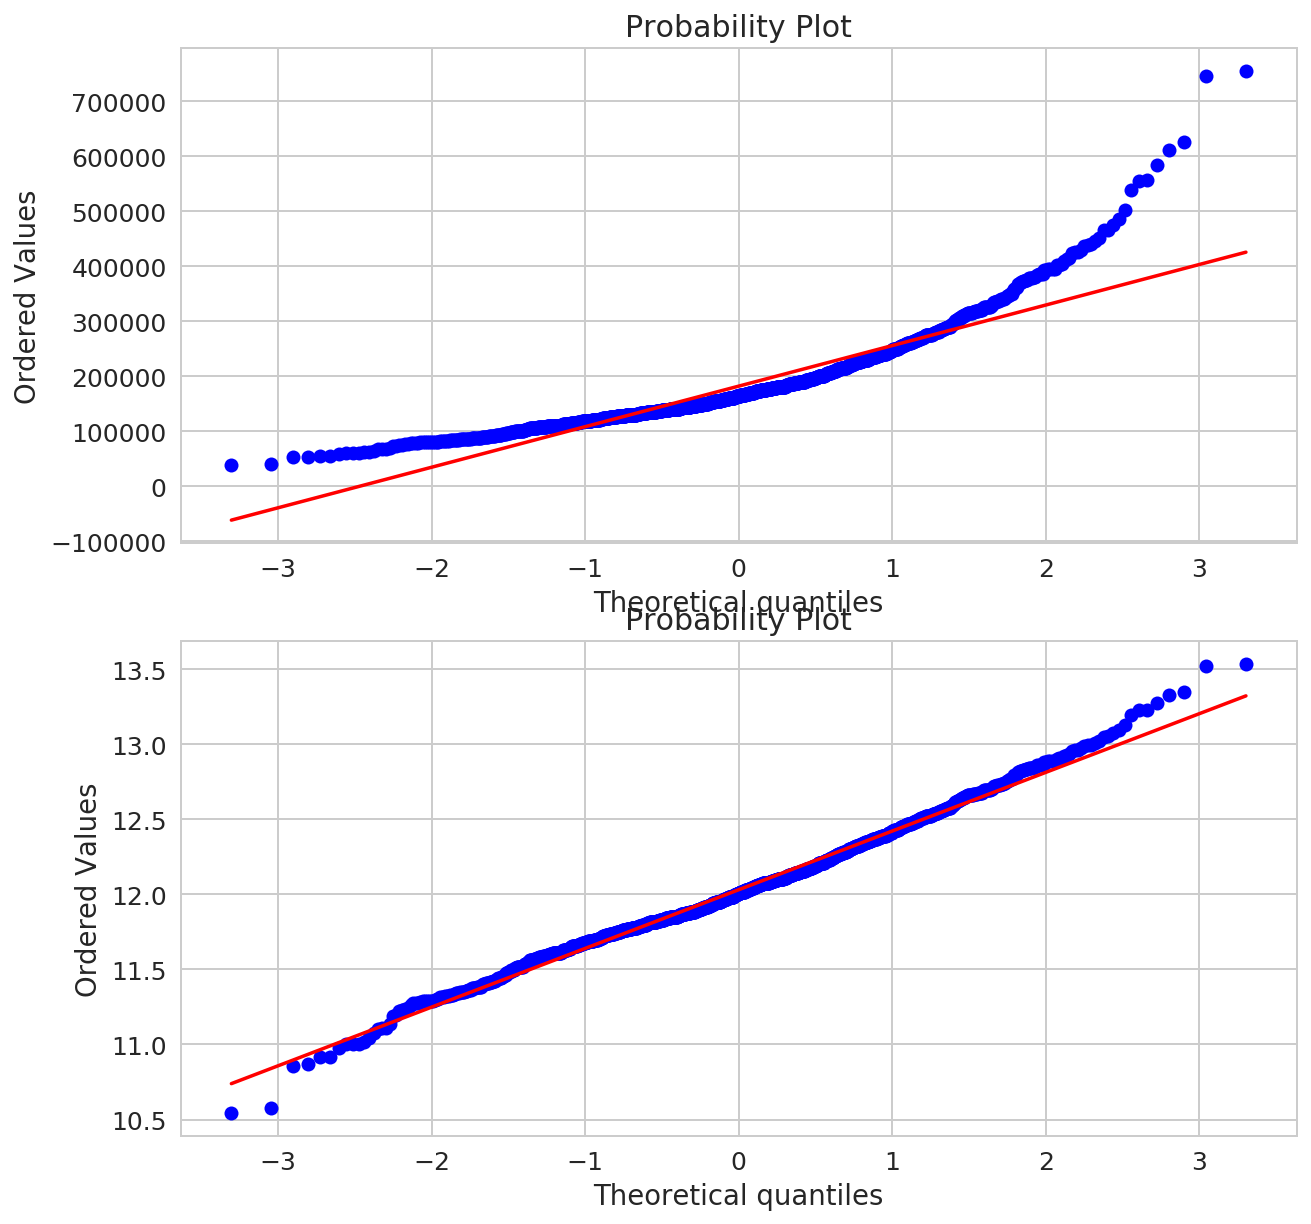

In [480]:
#saleprice
f, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
res = stats.probplot(h['SalePrice'], plot=ax1)
h['SalePrice'] = np.log(h['SalePrice'])
res = stats.probplot(h['SalePrice'], plot=ax2)

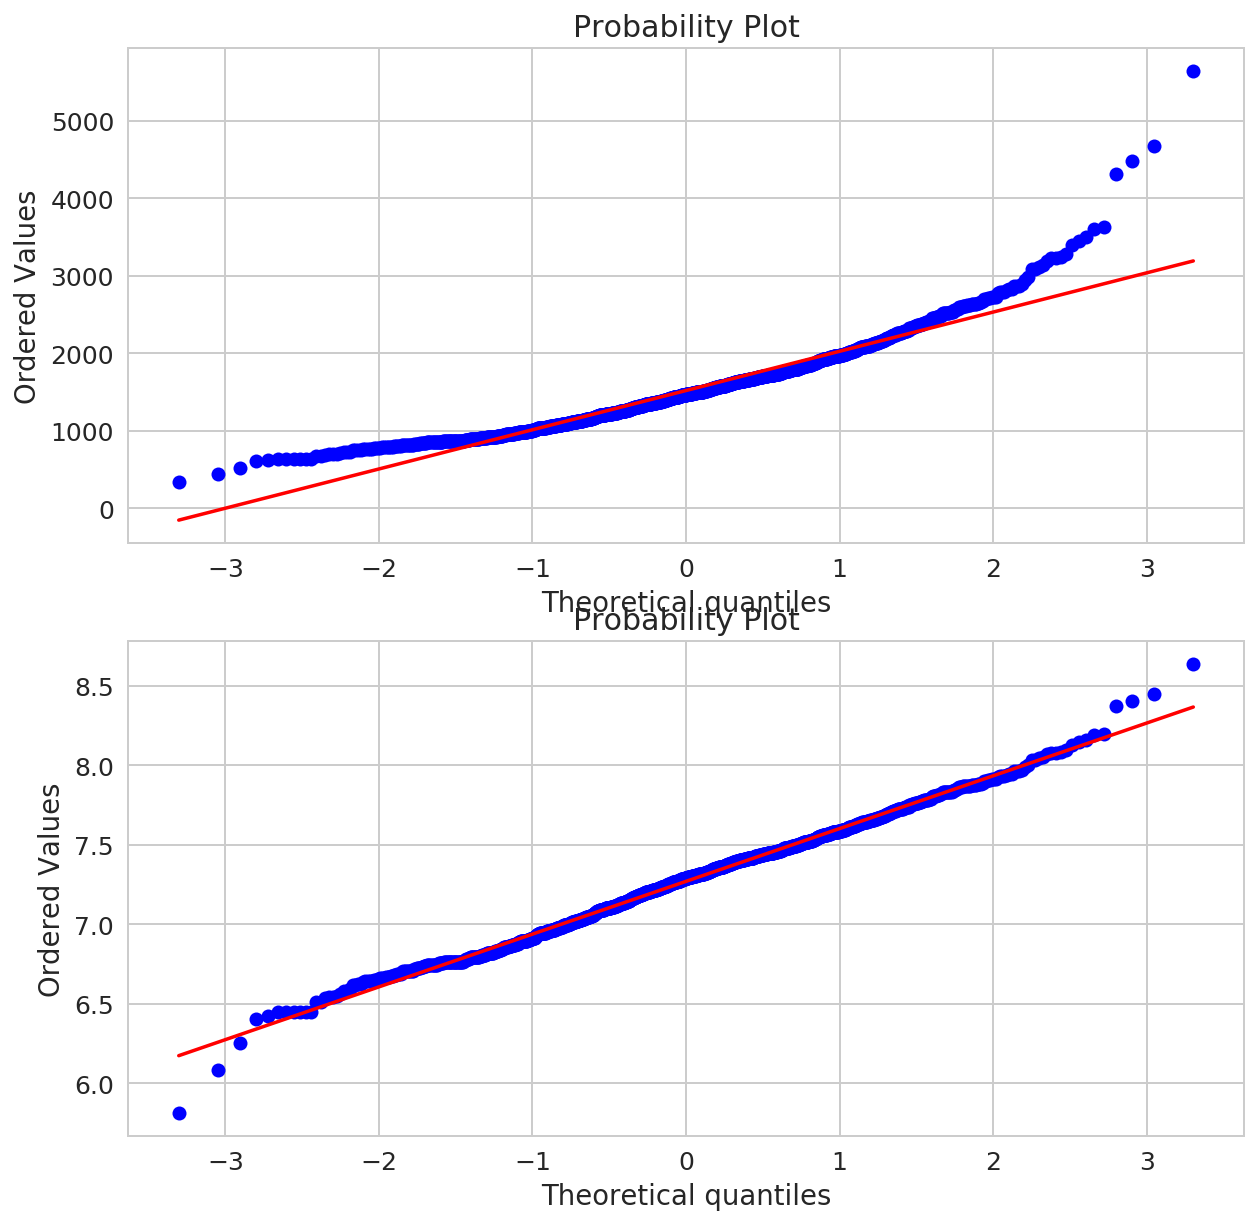

In [481]:
#GrLivArea
f, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
res = stats.probplot(h['GrLivArea'], plot=ax1)
h['GrLivArea'] = np.log(h['GrLivArea'])
res = stats.probplot(h['GrLivArea'], plot=ax2)

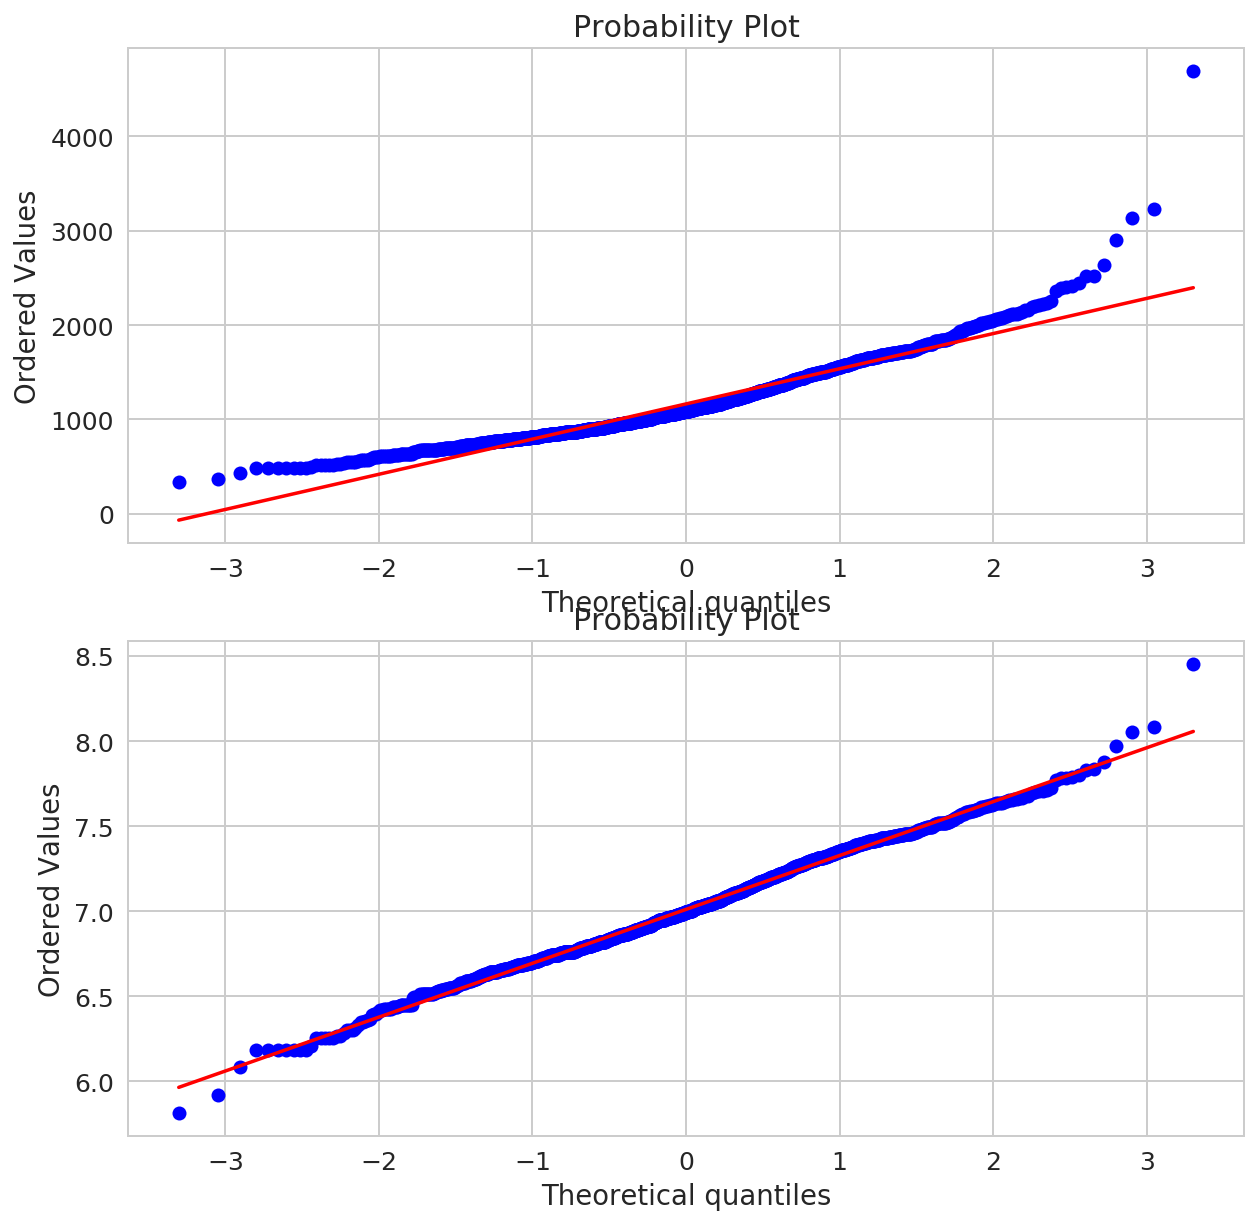

In [482]:
#1stFlrSF
f, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
res = stats.probplot(h['1stFlrSF'], plot=ax1)
h['1stFlrSF'] = np.log(h['1stFlrSF'])
res = stats.probplot(h['1stFlrSF'], plot=ax2)

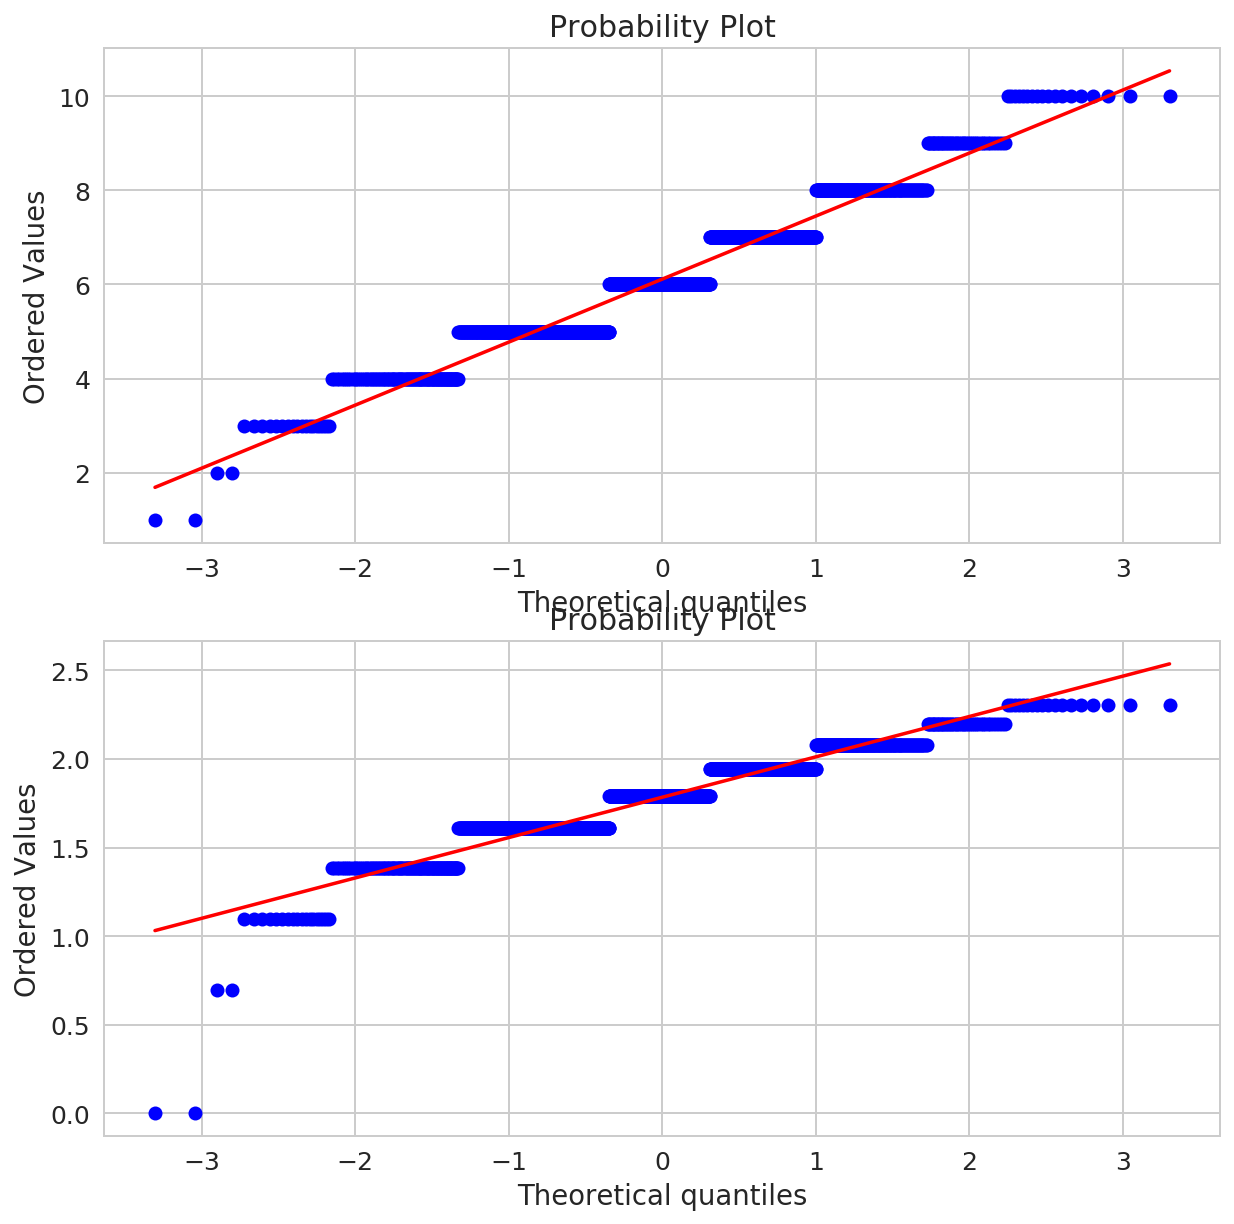

In [483]:
#OverallQual - debateable if this should have it
f, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
res = stats.probplot(h['OverallQual'], plot=ax1)
h['OverallQual'] = np.log(h['OverallQual'])
res = stats.probplot(h['OverallQual'], plot=ax2)

# Convert 0's in some numerics to categorical - BsmtSq

In [484]:
def Zeroconvert(num):
    if num == 0:
        out = 1
    else:
        out = 0
    return out
Zeroconvert(orig['TotalBsmtSF'][0])

0

In [485]:
#there are 37 samples without a basement
h['TotalBsmtSF'].value_counts().head()

0       37
864     35
672     17
912     15
1040    14
Name: TotalBsmtSF, dtype: int64

In [486]:
h['NoBsmt'] = h['TotalBsmtSF'].apply(Zeroconvert)

In [487]:
h['NoBsmt'].value_counts().head()

0    1413
1      37
Name: NoBsmt, dtype: int64

In [488]:
#there are 79 samples without a Garage
h['GarageArea'].value_counts().head()

0      79
440    49
576    47
240    38
484    34
Name: GarageArea, dtype: int64

In [489]:
h['NoGarage'] = h['GarageArea'].apply(Zeroconvert)

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


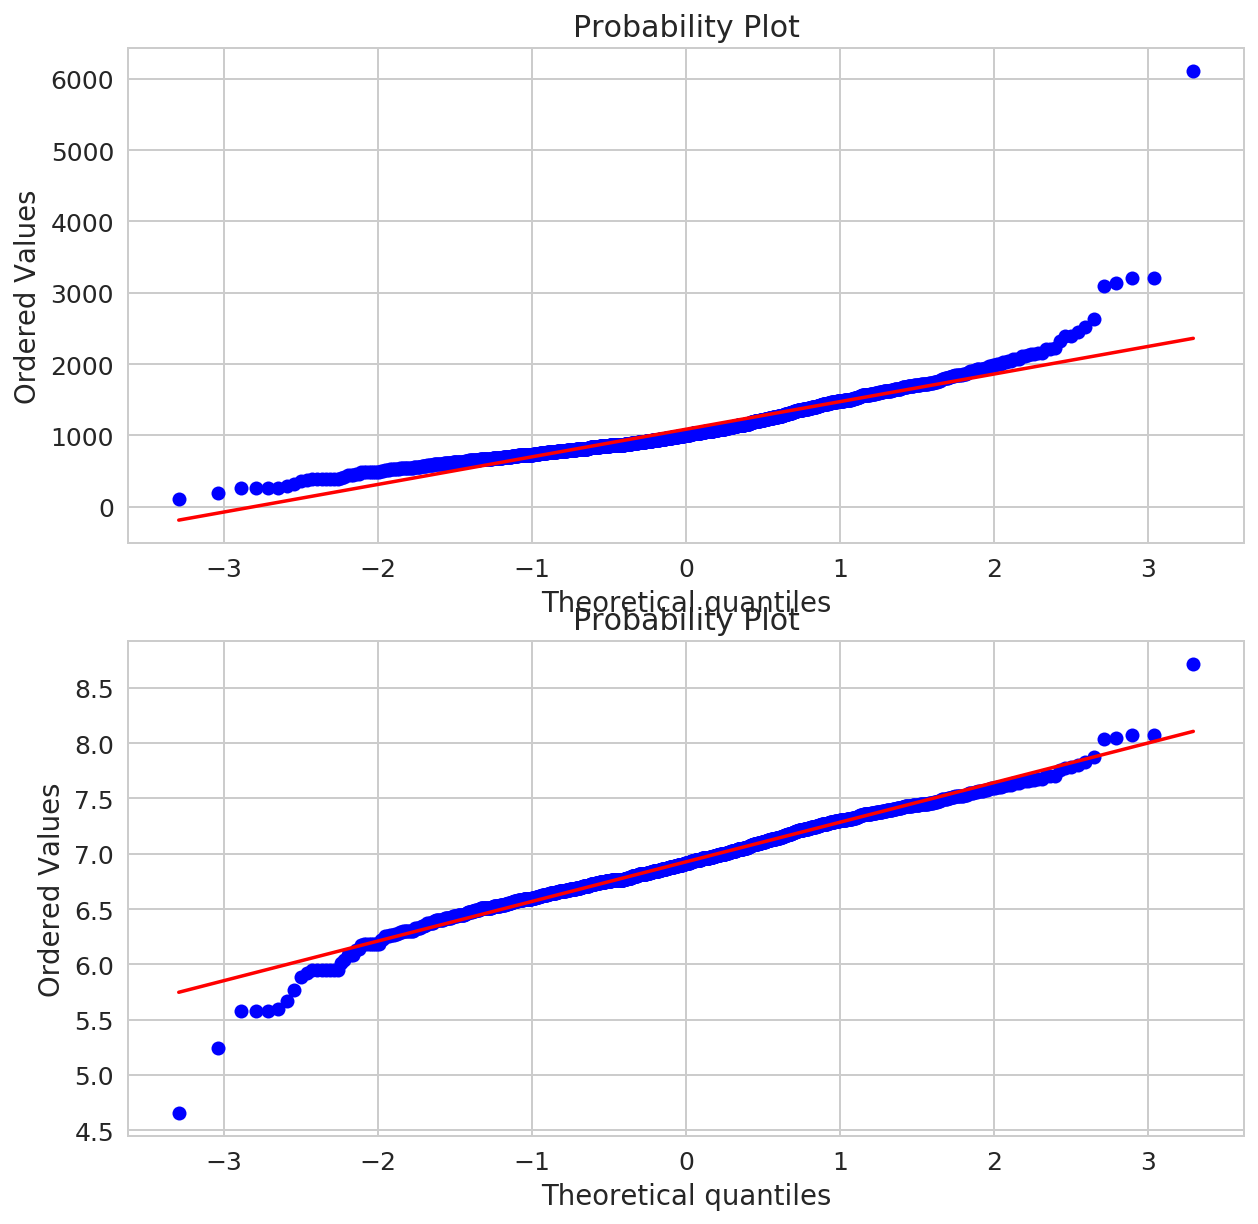

In [490]:
#TotalBsmtSF
f, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
res = stats.probplot(h[h['TotalBsmtSF'] > 0]['TotalBsmtSF'], plot=ax1)
h.loc[h['NoBsmt'] == 0,'TotalBsmtSF'] = np.log(h['TotalBsmtSF'])
res = stats.probplot(h[h['TotalBsmtSF'] > 0]['TotalBsmtSF'], plot=ax2)

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


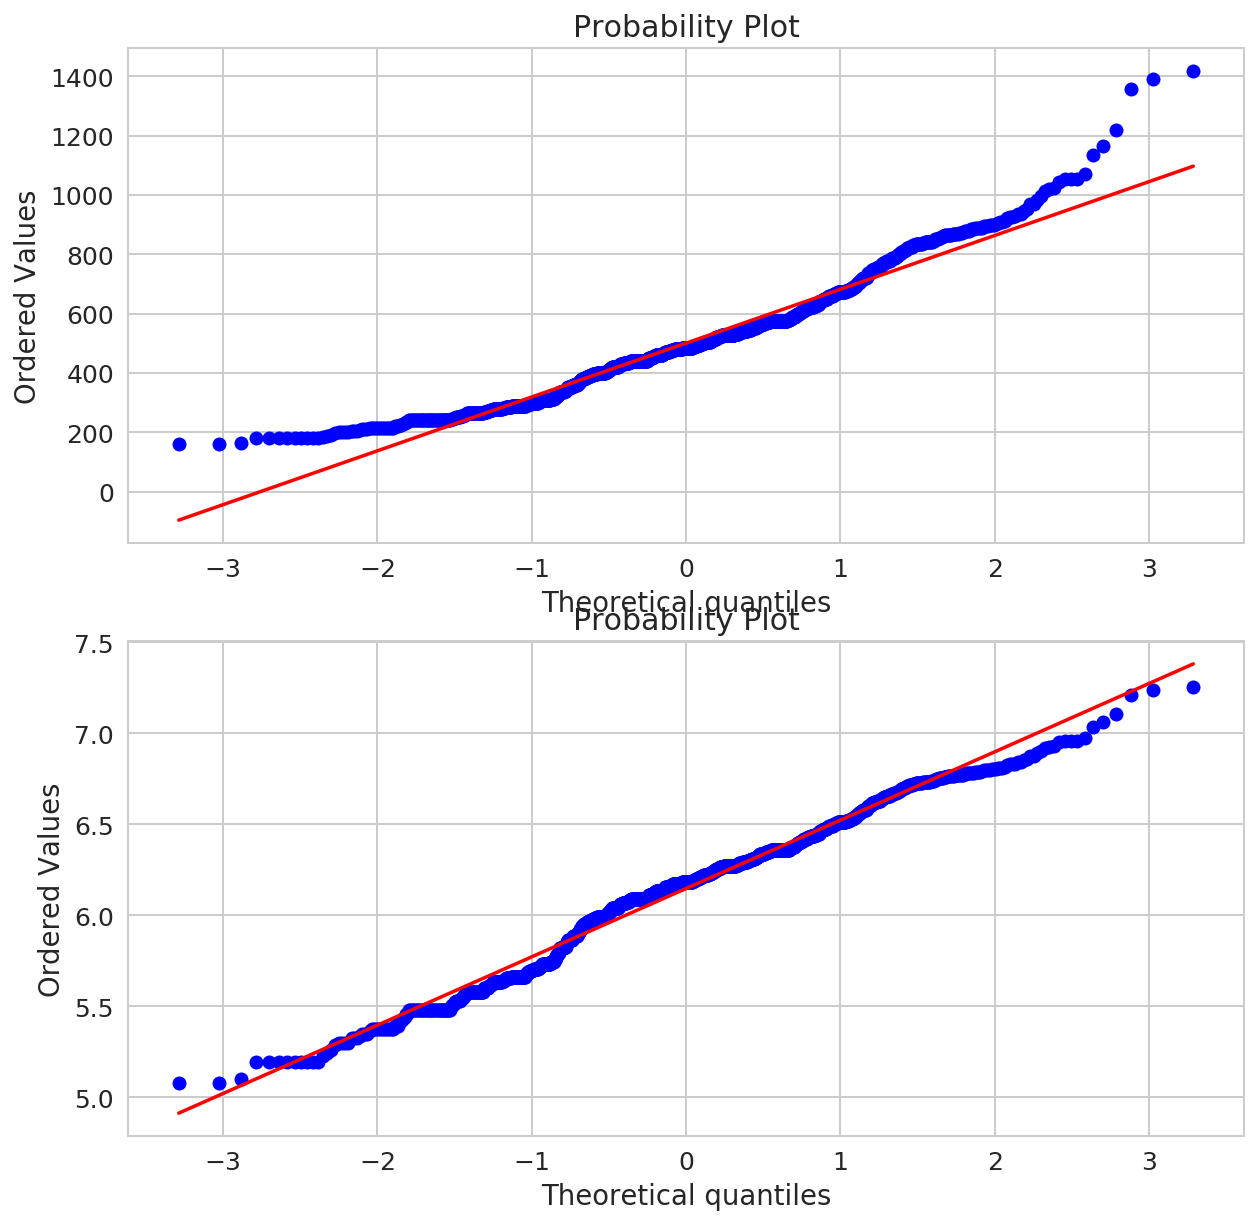

In [491]:
#GarageArea
f, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
res = stats.probplot(h[h['GarageArea'] > 0]['GarageArea'], plot=ax1)
h.loc[h['NoGarage'] == 0,'GarageArea'] = np.log(h['GarageArea'])
res = stats.probplot(h[h['GarageArea'] > 0]['GarageArea'], plot=ax2)

# Check distribution afterwards

In [492]:
# f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10) = plt.subplots(10,figsize=(7,36))
# sns.distplot(h['SalePrice'], fit=norm, ax=ax1)
# #ax1.set_title('SalePrice')
# sns.distplot(h['OverallQual'], fit=norm, ax=ax2)
# #ax2.set_title('OverallQual')
# sns.distplot(h['FullBath'], fit=norm, ax=ax3)
# sns.distplot(h['GrLivArea'], fit=norm, ax=ax4)
# sns.distplot(h['GarageArea'], fit=norm, ax=ax5)
# sns.distplot(h['GarageCars'], fit=norm, ax=ax6)
# sns.distplot(h['TotalBsmtSF'], fit=norm, ax=ax7)
# sns.distplot(h['1stFlrSF'], fit=norm, ax=ax8)
# sns.distplot(h['TotRmsAbvGrd'], fit=norm, ax=ax9)
# sns.distplot(h['YearBuilt'], fit=norm, ax=ax10)

# Copy of transformed data without dummies

In [493]:
h_no_dummy = h.copy()

In [508]:
#h = h_no_dummy.copy()

In [521]:
#h = h_no_log.copy()

# Add dummy cols

In [522]:
# #old version
# for col in h.columns:
#     if h[col].dtype == 'object':
#         h = pd.concat([h, pd.get_dummies(h[col])], axis=1)
#         del h[col]

In [523]:
#drop base case per dummies col
for col in h.columns:
    if h[col].dtype == 'object':
        dummies = pd.DataFrame()
        dummies = pd.get_dummies(h[col]).rename(columns=lambda x: str(col) + '_' + str(x))
        drop_col = str(col) + '_' + str(h[col].unique()[-1])
        h = pd.concat([h, dummies], axis=1)
        #h = pd.concat([h, pd.get_dummies(h[col])], axis=1)
        del h[col]
        del h[drop_col]

In [524]:
#categorize Mosold and any other categorical numerics into dummies too
col = 'MoSold'
dummies = pd.DataFrame()
dummies = pd.get_dummies(h[col]).rename(columns=lambda x: str(col) + '_' + str(x))
drop_col = str(col) + '_' + str(h[col].unique()[-1])
h = pd.concat([h, dummies], axis=1)
del h[col]
del h[drop_col]

In [525]:
#h.columns
#h['MSSubClassCat'].value_counts()[-1]
#h.groupby('MSSubClassCat')['MSSubClassCat'].size().min()
#h['MSSubClassCat'].unique()[-1]
#dummies = pd.get_dummies(h['MSSubClassCat']).rename(columns=lambda x: str('MSSubClassCat') + '_' + str(x))
#dummies = dummies.drop(dummies.columns[0],axis=1)
#len(dummies.columns)

# Add some features

In [526]:
#amount of high quality sqft
h['Qualsqft'] = (h.GrLivArea  - h.LowQualFinSF)

#2 story building, assuming multiple floors is a more desireable house
#h['2story'] = h['2ndFlrSF'] > 0
#h['Y' if h[h['2ndFlrSF'] > 0] else 'N']

#sqft of rooms other than bedrooms, indicitive of open concept?
h['oConcept'] = (h['1stFlrSF'] / (h.TotRmsAbvGrd - h.BedroomAbvGr + 1))

#rooms other than bedrooms
h['Rooms'] = (h.TotRmsAbvGrd - h.BedroomAbvGr)

#avg sqft per room
h['SqftPerRoom'] = (h.GrLivArea / h.TotRmsAbvGrd)

#yard size, based on lot size minus all other measured areas we have
h['Yard'] = h.LotArea - h['1stFlrSF'] - h.GarageArea# - h.WoodDeckSF - h.OpenPorchSF - h['3SsnPorch'] - h.ScreenPorch

#bathroom to bed ratio, weighting halfbaths appropriately
h['Bath2Bed'] = ((h.FullBath + (h.HalfBath)*.5) / (h.BedroomAbvGr + 1))

#bathroom to kitchen ratio, weighting halfbaths appropriately
h['Bath2Kitch'] = ((h.FullBath + (h.HalfBath)*.5) / (h.KitchenAbvGr + 1))

#overall quality squared
h['OverallQualSq'] = h['OverallQual'] ** 2

h['QualOnLot'] =  (h['Qualsqft'] ** h['OverallQualSq'])

h['QualOnSqft'] =  (h['GrLivArea'] * h['OverallQualSq'])

h['QualOnRooms'] =  ((h['BedroomAbvGr'] + h['KitchenAbvGr'] + 
                      h['TotRmsAbvGrd'] + h['GarageCars'] + 
                      h['FullBath'] + h['HalfBath'] + 
                      h['BsmtFullBath'] + h['BsmtHalfBath'] + h['Fireplaces']) * h['OverallQualSq'])

h['RoomsOverArea'] = h['TotRmsAbvGrd'] / h['GrLivArea']

#price per bed
#h['PriceRoom'] = h['SalePrice'] / h['TotRmsAbvGrd']# + h['FullBath'] + h['HalfBath']

#price per bed
#h['PriceBed'] = h['SalePrice'] / h['BedroomAbvGr']
#h['SalePrice'] / h['BedroomAbvGr']

#years since renovations
h['YearsBetween'] = h['YearRemodAdd'] - h['YearBuilt']

h['Qualsqft2'] = np.sqrt(h['Qualsqft']) * h['OverallQual'] # * h['sqftperroom']
#h['Qualsqft2'].fillna(0)

h['Qualsqft3'] = np.sqrt(h['Qualsqft']) * h['OverallQualSq'] # * h['sqftperroom']
#h['Qualsqft3'].fillna(0)

h['BKG'] =  (h['Bath2Bed'] * h['Qualsqft'])

#h['PriceOnRooms'] =  (h['SalePrice'] / (h['BedroomAbvGr'] + h['KitchenAbvGr'] + h['TotRmsAbvGrd']))

h['BKP'] =  (h['Bath2Kitch'] * h['QualOnRooms'])

In [527]:
#add features
#(h.groupby('Neighborhood')['SalePrice'].mean() / h.groupby('Neighborhood')['GrLivArea'].mean()).sort_values(ascending=False)

In [528]:
#h['Qualsqft2']
h['Qualsqft2'].fillna(0,inplace=True)
h['Qualsqft3'].fillna(0,inplace=True)
h['QualOnLot'].fillna(0,inplace=True)

# Take a look at the corr of new features I added.
- They are built off one another there is a high correlation between each other. 
- They may be less useful than it looks, but for now they show strong correlations to the saleprice

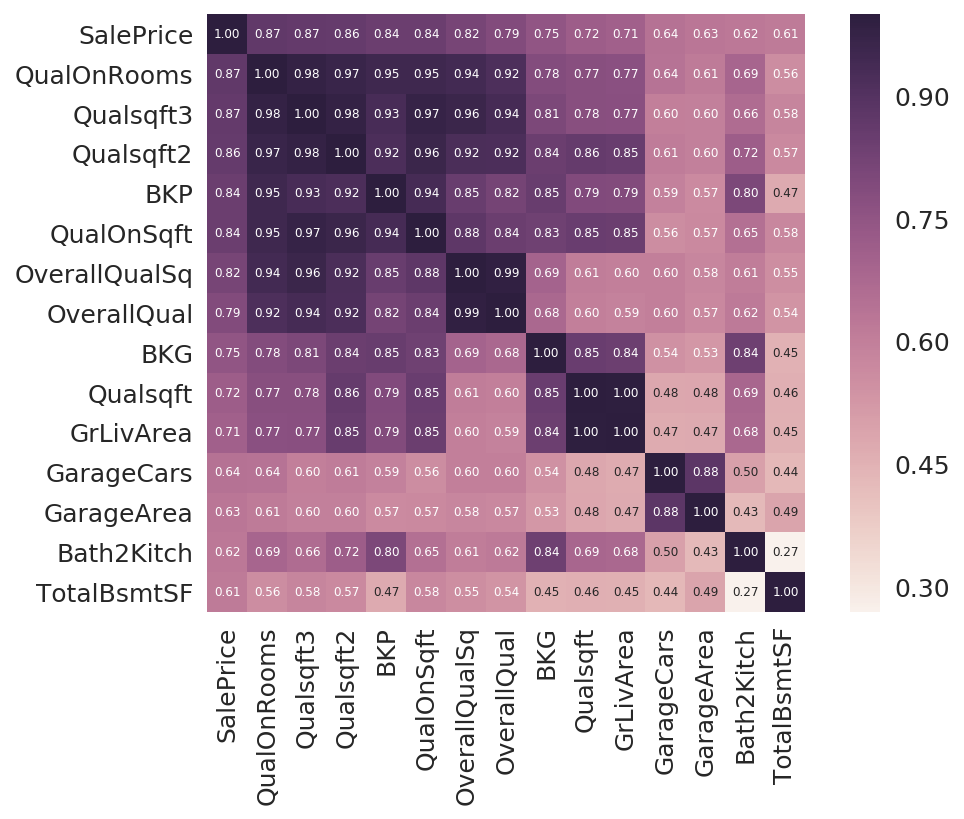

In [529]:
#saleprice correlation matrix
k = 15 #number of variables for heatmap
corr = h.corr()
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(h[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, 
                 fmt='.2f', annot_kws={'size': 6}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Make sure added cols have non Nans

In [530]:
#h.fillna(0,inplace=True)
h.isnull().sum().sort_values(ascending=False).head()

BKP                  0
HouseStyle_1.5Unf    0
Condition2_RRNn      0
BldgType_1Fam        0
BldgType_2fmCon      0
dtype: int64

# Start Evaluation of data
- h_log_dummy is the fully log transformed and categorical dummy dataframe
- h_no_transforms is the original data cleaned
- h_no_dummy is log transformed, but doesn't have categorical dummy variables
- h_dummy is not transformed but has dummy variables

In [806]:
#h = h_dummy.copy()
h = h_log_dummy.copy()

# Create a fixed and non-fixed feature dataframes to evaluate separately

In [761]:
h_fixed = h_log_dummy.copy()

In [762]:
#fixed features only
fixed_col = []
for col in h_fixed.columns:
    for fix in feature_dict['fixed']:
        if fix in col:
            #del h_fixed[col]
            fixed_col.append(col)
h_fixed = h_fixed[fixed_col]

In [614]:
#non-fixed features only
nonfixed_col = []
for col in h_nonfixed.columns:
    for nonfix in feature_dict['non-fixed']:
        if nonfix in col:
            #del h_fixed[col]
            nonfixed_col.append(col)
h_nonfixed = h_nonfixed[nonfixed_col]

In [649]:
h = h_nonfixed.copy()
#h = h_fixed.copy()

# Remove the target variable

In [927]:
y = h['SalePrice']
X = h.drop("SalePrice", axis=1)
Xn = h.drop("SalePrice", axis=1)

In [928]:
#X = h
print(X.shape)
print(y.shape)

(1450, 282)
(1450,)


In [929]:
#y

In [930]:
#h = pd.concat([h,y],axis=1)
#h.describe().T.head()

# Scale it

In [931]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)
X = pd.DataFrame(X,columns=Xn.columns)

# Create Holdouts

In [932]:
from sklearn.model_selection import train_test_split
X_train, X_hold, y_train, y_hold = train_test_split(X,y,test_size=0.2)

# Create new test/train set off the non-holdout terms

In [933]:
X = X_train.copy()
y = y_train.copy()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [934]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.89161406125676701

In [935]:
zip(X.columns,lr.coef_)[:5]

[('LotArea', 0.015194232254568715),
 ('OverallQual', 0.06341030655975588),
 ('OverallCond', 0.053195451319589512),
 ('YearBuilt', 0.038812272520302879),
 ('YearRemodAdd', 0.026600781182491776)]

In [936]:
np.e**lr.intercept_

167735.23624045087

# Lets get a more confident value, and run the lr through cross validation
#### Okay, our R2 value got hammered. But it typically falls when comparing test/train to cross-val

In [937]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, random_state=4)
score = cross_val_score(lr,X,y,scoring='neg_mean_squared_error',cv=kfold)
positive_score = -score
np.sqrt(positive_score).mean()

0.1674912204458856

In [938]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, random_state=4)
score = cross_val_score(lr,X,y,scoring='r2',cv=kfold)
np.mean(score)

0.81151739756911334

# Look at all those coeficients! This needs some regularization.
#### AKA: this needs to be simplified. Regularization injects bias into the model and limits the values of the coeficients based on an alpha value


In [939]:
from sklearn import linear_model

In [940]:
a = [.0005,.0008,.001,.002,.0025,.003,.0035,.004,.005,.01,.05,.1]
score = []
for i in a:
    reg = linear_model.Lasso(alpha = i)
    reg.fit(X_train,y_train)
    score.append(reg.score(X_test,y_test))
zip(a,score)

[(0.0005, 0.91367801327656617),
 (0.0008, 0.91272957288599066),
 (0.001, 0.91162488174821521),
 (0.002, 0.90588278643285403),
 (0.0025, 0.90609759901033826),
 (0.003, 0.90774554714791678),
 (0.0035, 0.90919767373116978),
 (0.004, 0.91074836299348938),
 (0.005, 0.9127563836801329),
 (0.01, 0.91242456636936375),
 (0.05, 0.81924187528056669),
 (0.1, 0.72974078910687634)]

# This looks promising but again, we should take a look at the cross-val scores to get a more realistic score. Lets make a function to put a model into the Kfolds and return RMSE

In [941]:
def cv_rmse(estimator):
    score = cross_val_score(estimator,X,y,scoring='neg_mean_squared_error',cv=kfold)
    positive_score = -score
    return np.sqrt(positive_score) #np.sqrt(positive_score)

In [942]:
cv_rmse(lr).mean()

0.1674912204458856

# Lasso cross validation with cv=10 and alpha=[that list]
#### Leads to sparsity and simplification of a model, which is very good in this case because we want to be able to explain the outcome of salesprice in terms of the coeficients

In [943]:
a = [.0005,.0008,.001,.002,.003,.004,.005,.01,.05]
Lasso_rmse = []
Lasso_std = []
for i in a:
    Lasso_rmse.append(cv_rmse(linear_model.Lasso(alpha=i)).mean())
    Lasso_std.append(cv_rmse(linear_model.Lasso(alpha=i)).std())
    

In [944]:
from pprint import pprint
ls = zip(a,Lasso_rmse,Lasso_std)
ls = pd.DataFrame(ls,columns=['Alpha','RMSE','Std'])

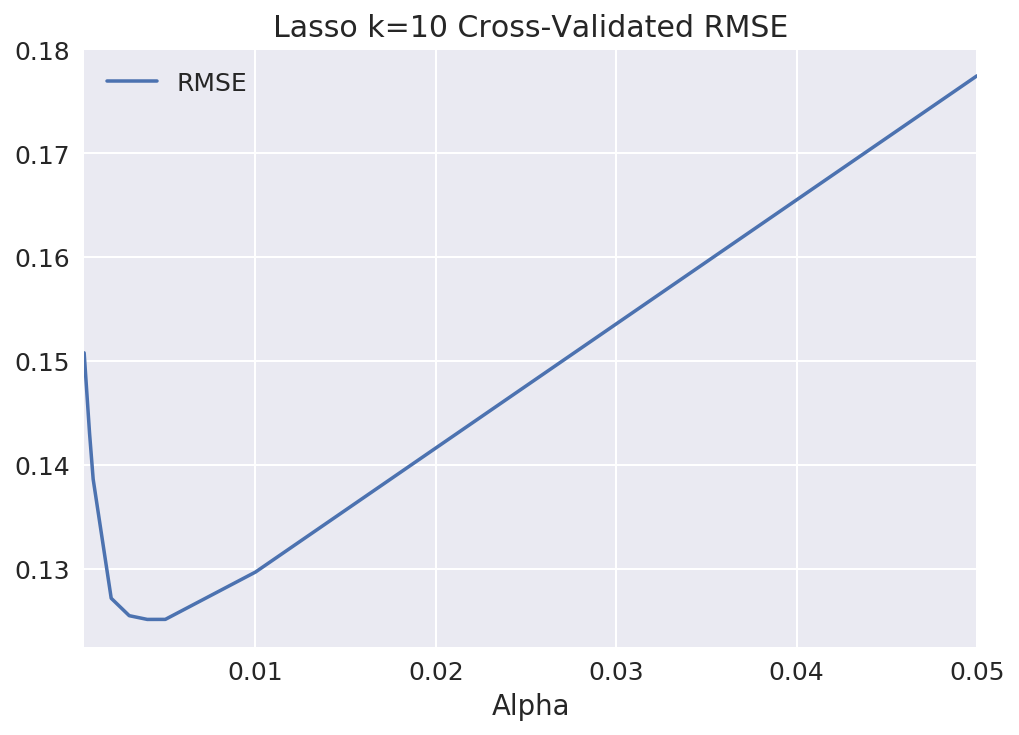

In [945]:
ls.plot('Alpha','RMSE',title='Lasso k=10 Cross-Validated RMSE')

In [946]:
# import pylab
# from scipy.stats import norm

# for i in range(len(ls)):
#     xp = np.linspace(.05,.3,100)
#     yp = norm.pdf(xp, loc=ls[i][1], scale=ls[i][2])    # for example
#     pylab.plot(xp,yp,label=ls[i][0])
#     pylab.legend()
#     #ax.legend(loc='upper center', shadow=True)
# pylab.show()

# Train Lasso model on best hyperparameter alpha

In [947]:
lasso = linear_model.Lasso(alpha=.004)
lasso.fit(X,y)
Lasso_coef = pd.DataFrame(lasso.coef_,index=Xn.columns)

In [948]:
lasso.score(X_hold,y_hold)

0.91565294037637679

In [952]:
print(X_hold.shape)
print(y_hold.shape)
print(y_pred.shape)

(290, 282)
(290,)
(290,)


In [949]:
y_pred = lasso.predict(X_hold)

In [965]:
#X_hold.reset_index()
lasso_pred = pd.concat([X_hold.reset_index(),y_hold.reset_ndex(),pd.DataFrame(y_pred,columns=['Pred_SalePrice'])],axis=1)

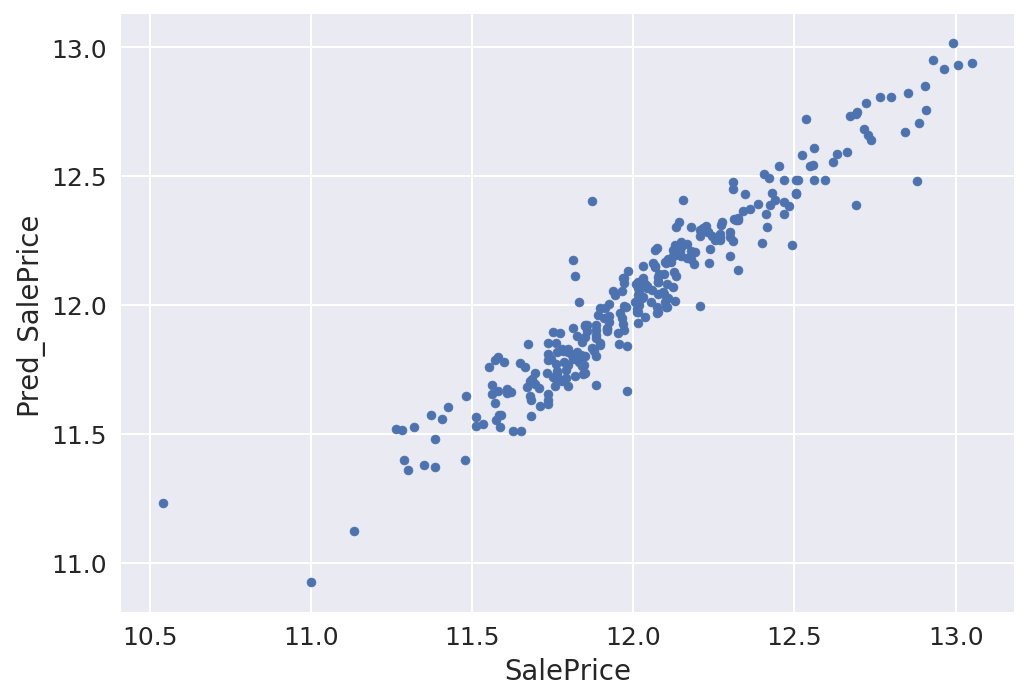

In [969]:
lasso_pred.plot.scatter('SalePrice','Pred_SalePrice')

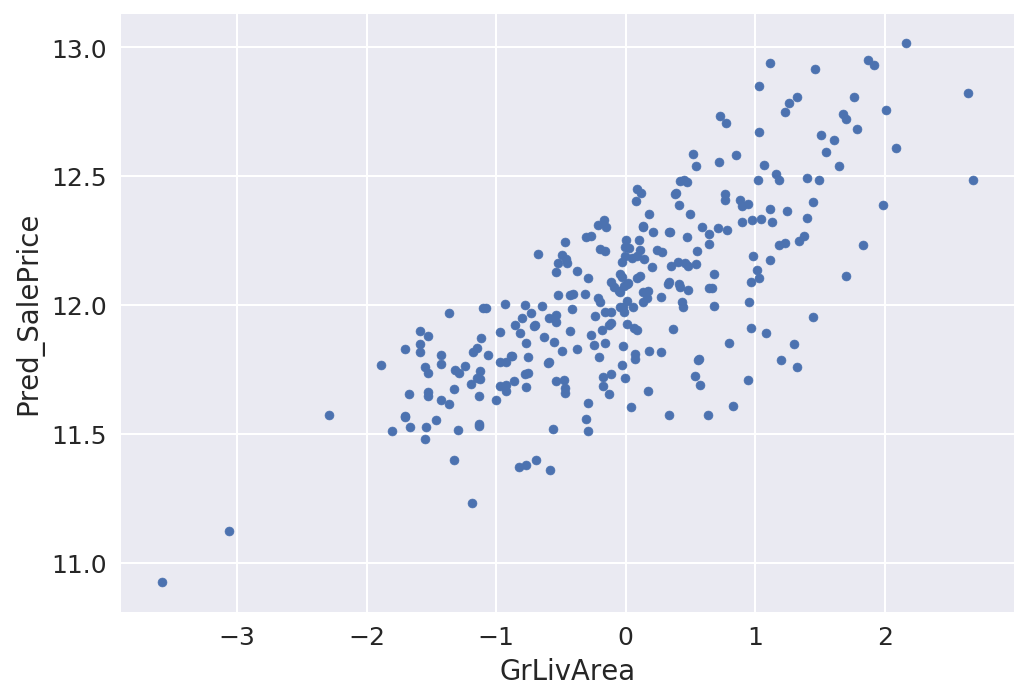

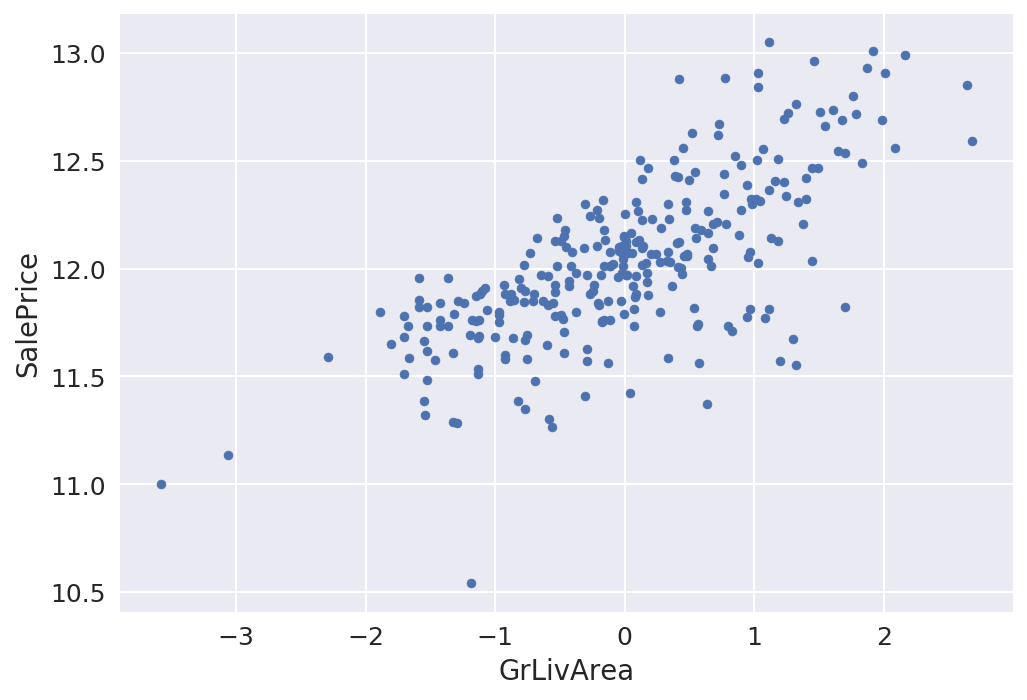

In [971]:
lasso_pred.plot.scatter('GrLivArea','Pred_SalePrice')
lasso_pred.plot.scatter('GrLivArea','SalePrice')

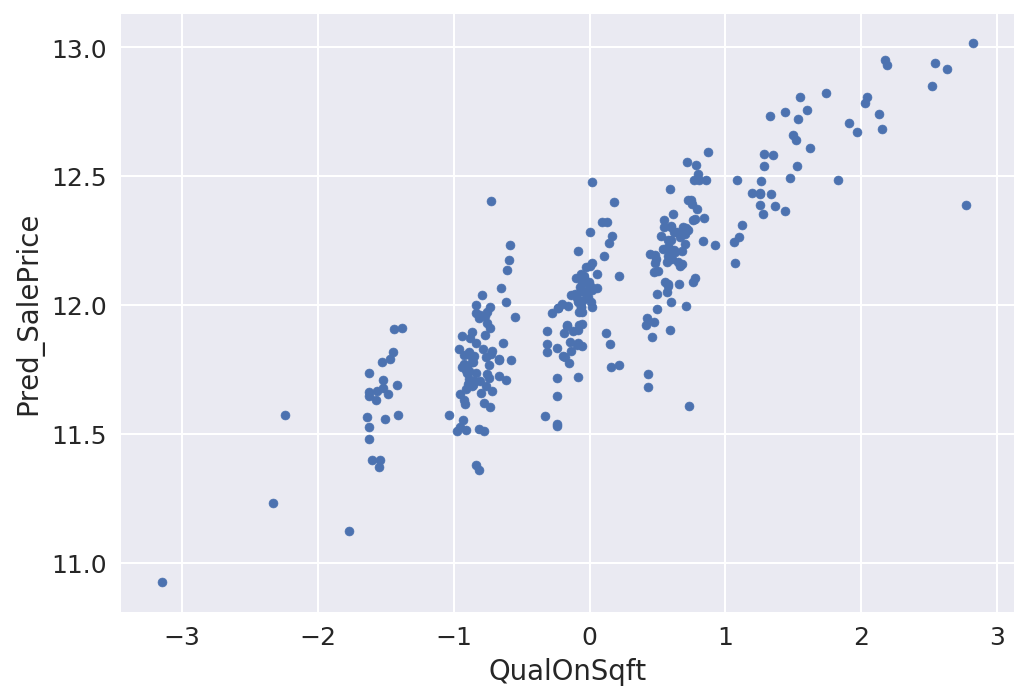

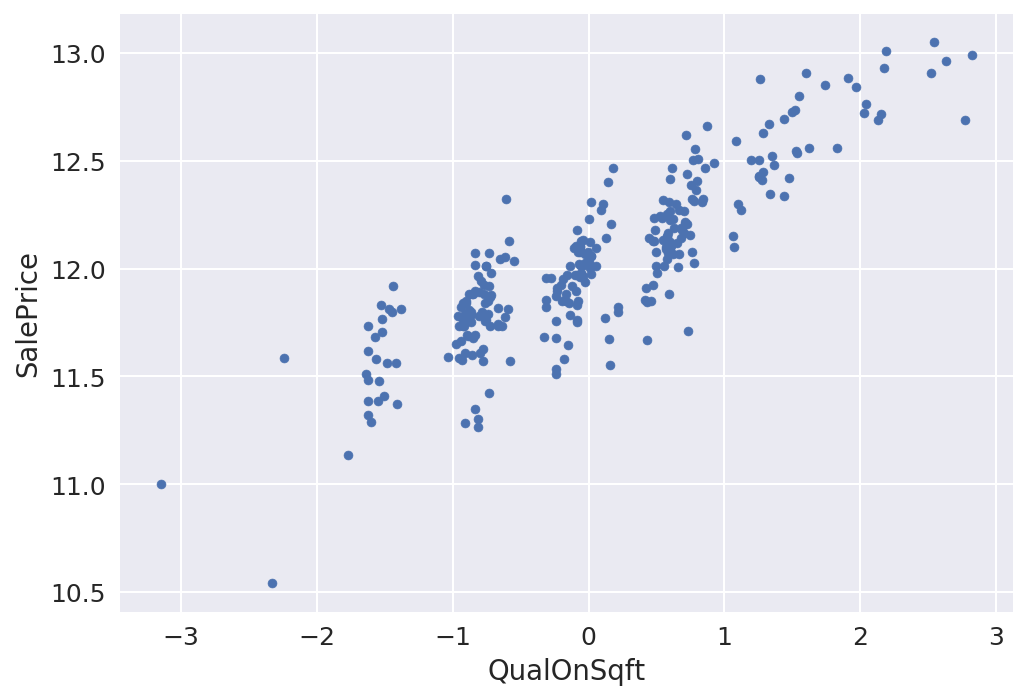

In [973]:
lasso_pred.plot.scatter('QualOnSqft','Pred_SalePrice')
lasso_pred.plot.scatter('QualOnSqft','SalePrice')

# Lasso strength of top 20 coef (out of 53 Lasso selected)

In [852]:
#pd.options.display.float_format = '{:,.6f}'.format
#print(Lasso_coef[Lasso_coef[0] > 0].sort_values(by=0,ascending=False).head(20))
print('\nnum of coefs: ' + str(Lasso_coef[Lasso_coef[0] > 0].count()))
print('\n')
print(np.e**lasso.intercept_)


num of coefs: 0    55
dtype: int64


167532.692745


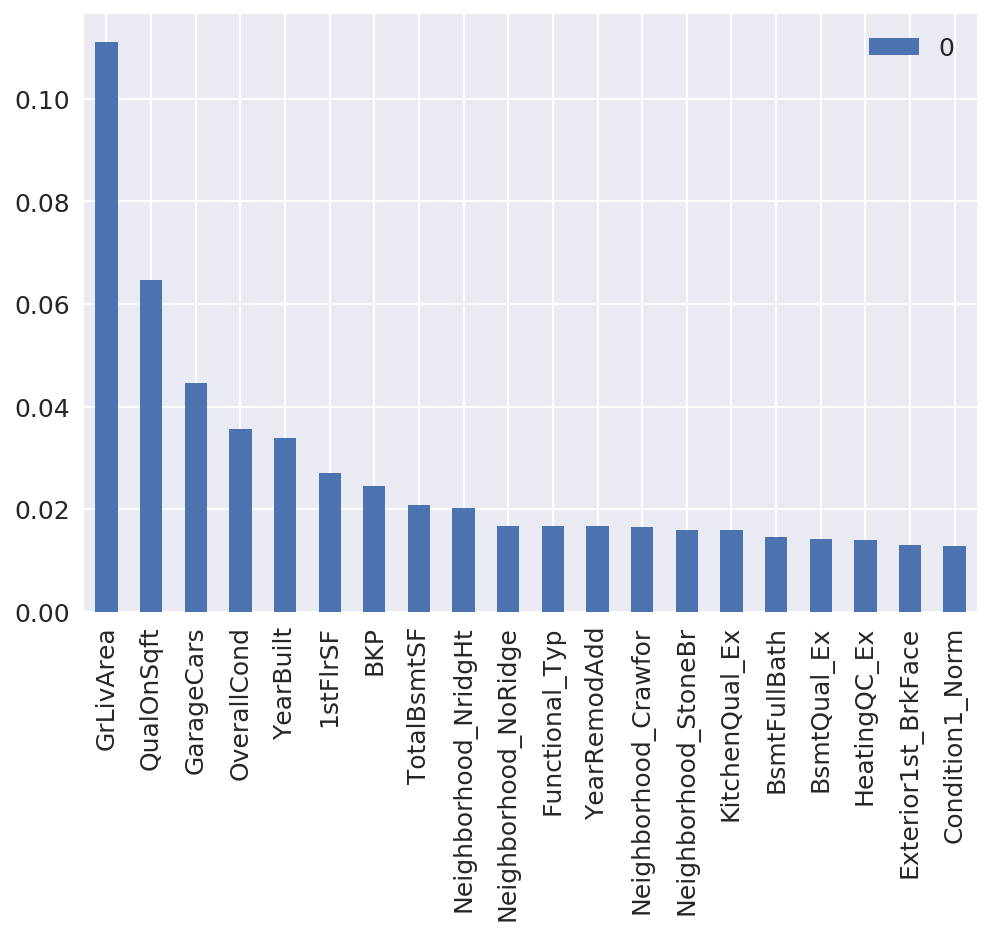

In [829]:
Lasso_coef[Lasso_coef[0] > 0].sort_values(by=0,ascending=False).head(20).plot.bar()

In [831]:
#h[list(Lasso_coef[Lasso_coef[0] > 0].index)].mean()
InvScale = pd.DataFrame()
InvScale['mean'] = h[list(Lasso_coef[Lasso_coef[0] > 0].index)].mean()
InvScale['std'] = h[list(Lasso_coef[Lasso_coef[0] > 0].index)].std()

In [840]:
#InvScale.head()

In [841]:
#InvScale.loc['LotArea','mean']
#Lasso_coef

In [834]:
for feat in list(Lasso_coef[Lasso_coef[0] > 0].index):
    Lasso_coef.loc[feat,1] = Lasso_coef.loc[feat,0] * InvScale.loc[feat,'std'] + InvScale.loc[feat,'mean']
Lasso_coef.columns=['coef','converted']

In [893]:
#Fixed_coef = Lasso_coef.sort_values(by='coef',ascending=False)
#h_log_dummy_coef = Lasso_coef.sort_values(by='coef',ascending=False)
#h_dummy_coef = Lasso_coef.sort_values(by='coef',ascending=False)

#Without transforms these are the coeficients
#h_dummy_coef['coef']

#with transforms
a = pd.DataFrame(h_log_dummy_coef['coef'])#.sort_values(by=index)
a = a.reindex_axis(sorted(a.index), axis=0)

#Lasso_coef.sort_values(by='coef',ascending=False)

In [974]:
#a[a['coef'].abs() > 0]

# The intercept is: 167,532.
- Because I took the log of the sale price I believe it is the geometric mean. Therefore all other coefs are interpreted on a perent increase from the mean.

# My interpretation of the coeficients:
- Every 1 unit increase in above ground living area contributes to 12% increase in the sale price
    - I wish I had a more reasonable explanation but I tried running the model without the transformed data and it was uninterpretable
- Every 1 unit increase in the combo of GrLivArea * OverallQual^2 contributes to a 6% increase in sale price
    - I thought this was a good metric to include because it takes into account the quality as well as the size
- Every extra car the garage can fit increases the sale price by 4.4%
- Every year increase in date build adds 3.8% to the sale price
- Every 1 unit increase in overall condition increases the sale price 3.2%

http://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqhow-do-i-interpret-a-regression-model-when-some-variables-are-log-transformed/

# Renovatable features:
- If buying to renovate, purchase houses with:
    - kitchens needing an upgrade (2 point upgrade = 7k increase, though this doesn't make sense intuitively)
    - overall condition needing an upgrade
    


# I do not yet trust my model
- Intuatively I was able to pull a lot more infomation during the EDA process than I can effectively pull from my model. 
- EDA led me to believe purchasing a single family in an up and coming part of town - maybe the 4-6th top neighborhoods would be a good investiment due to the disparity in price between single family homes in the top neighborhoods and the row houses in the others.
- If i could invest my time in the project again, I would reevaluate the model output in each step of complexity.